## Problem 1: Convolution Responses

In [1]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
%matplotlib inline

In [2]:
import numpy as np
from scipy.signal import convolve2d

import copy

from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
from tqdm import tqdm
from skimage.color import rgb2gray

Read the image

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


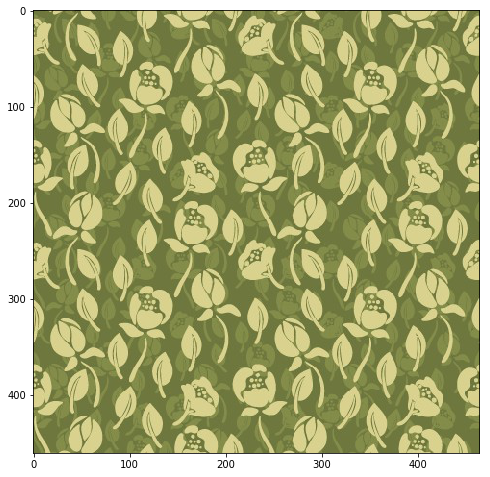

In [3]:
img = imread('Vintage-green-flower-seamless-pattern.jpg')
plt.figure(figsize = (8,10))
plt.imshow(img)
img = resize(img, (256, 256), preserve_range=True)[:,:,0]

## Find the centers of big flower patterns.

### Take the following sample of flower-pattern:

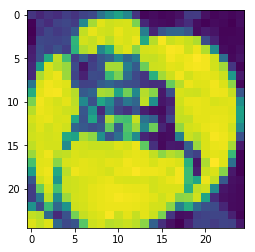

In [4]:
t, l, b, r = 159, 184, 184, 209
kernel = img[t:b, l:r]
plt.imshow(kernel)

In [5]:
def get_pattern(img, kernel):
    img = copy.deepcopy(img)
    kernel = copy.deepcopy(kernel)
    
    tilde_A = convolve2d(img, kernel, boundary='symm', mode='same')
    overline_A = np.sqrt(convolve2d(np.square(img), np.ones(kernel.shape), boundary='symm', mode='same'))
    result = tilde_A / overline_A 
    return result

In [6]:
result = get_pattern(img/255., kernel/255.)

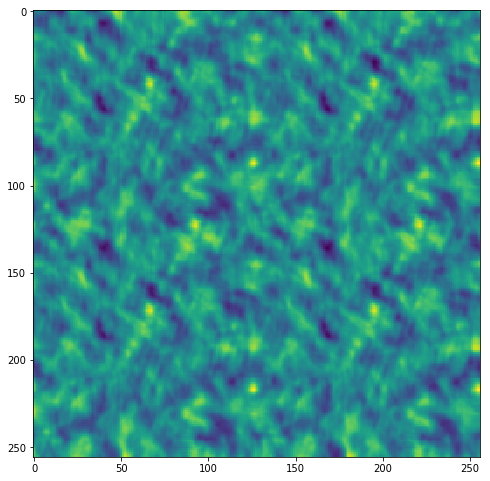

In [7]:
result = result / result.max()
plt.figure(figsize = (8,10))
plt.imshow(result)

### Determine some threshold to get acceptable result.

In [8]:
result

array([[0.96042884, 0.96144663, 0.96232662, ..., 0.96713895, 0.96916914,
        0.97409884],
       [0.95621658, 0.9569752 , 0.95840126, ..., 0.96387774, 0.96624992,
        0.97080752],
       [0.95546561, 0.95521765, 0.95638642, ..., 0.96121431, 0.9632154 ,
        0.96677525],
       ...,
       [0.9820154 , 0.97634324, 0.96930484, ..., 0.96005085, 0.96319785,
        0.96521239],
       [0.98149071, 0.97670566, 0.97245227, ..., 0.9596189 , 0.96373919,
        0.96724123],
       [0.98049275, 0.97739241, 0.97587346, ..., 0.95968394, 0.96414536,
        0.96862252]])

In [9]:
'define some treshold'
treshold = 0.99 # TODO Determine a THRESHOLD

In [10]:
centers = result.copy()
centers[result>=treshold] = 1
centers[result<treshold] = 0

Visualize the result

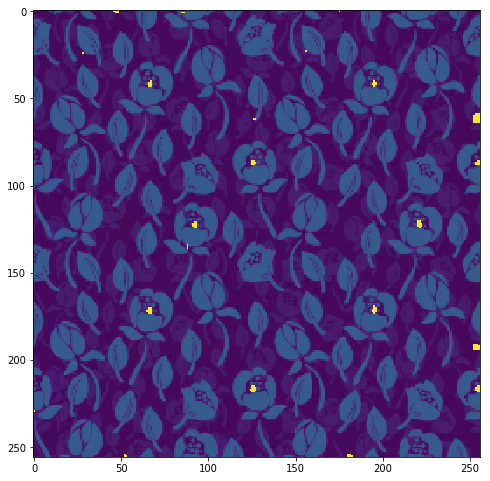

In [11]:
vis = img/255.
vis[centers==1] = 1
vis[centers!=1] *= 0.5
plt.figure(figsize = (8,10))
plt.imshow(vis)

## (Suplementary) Problem 2: Implement the following geometric transformation for images (with any interpolation you like):
$$
T:\mathbb{R}^2\rightarrow \mathbb{R}^2
\qquad T(x,y) = ((y^2+1)e^x - cos^2y, y^3)
$$

In [12]:
def Transformation(pixel):
    """
    Transformation
    
    Parameters:
        pixel (tiple or list)
        
    Returns:
        Transformed values
    """
    x, y = pixel[0], pixel[1]
    return (np.power(y, 2) + 1) * np.exp(x) - np.power(np.cos(y), 2), np.power(y, 3)

<img style="transform: rotate(90deg); width:800px" src="Inv_Transform.JPG" alt="sieve shaker" title="Title text" />

In [13]:
def Transformation_Inv(pixel):
    """
    Inverse Transformation of pixel
    
    Parameters:
        pixel
        
    Returns:
        Inverse Transformed values
    """
    x, y = pixel[0], pixel[1]
    return (np.log((x + np.power(np.cos(np.power(y, 1/3)), 2)) / (np.power(y, 2/3) + 1)), np.power(y, 1/3))

In [14]:
def bilinear_interpolate(img, pixel):
    """
    Bilinear Interpolation
    
    Parameters:
        img(matrix) - initial unchanged image
        pixel(tuple or list of 2 elements)
        
    Return:
        float(interpolated value)
    """
    
    H, W = img.shape
    x = np.asarray(pixel[0])
    y = np.asarray(pixel[1])
    
    x_0 = np.floor(x).astype(int)
    x_1 = x_0 + 1
    y_0 = np.floor(y).astype(int)
    y_1 = y_0 + 1
    
    x_0 = np.clip(x_0, 0, H - 1)
    x_1 = np.clip(x_1, 0, H - 1)
    y_0 = np.clip(y_0, 0, W - 1)
    y_1 = np.clip(y_1, 0, W - 1)
    
    a_0 = img[ x_0, y_0 ]
    a_1 = img[ x_0, y_1 ]
    a_2 = img[ x_1, y_0 ]
    a_3 = img[ x_1, y_1 ]
    
    w_a_0 = (x - x_0) * (y - y_0)
    w_a_1 = (x - x_0) * (y_1 - y)
    w_a_2 = (x_1 - x) * (y - y_0)
    w_a_3 = (x_1 - x) * (y_1 - y)
    
    return w_a_0 * a_3 + w_a_1 * a_2 + w_a_2 * a_1 + w_a_3 * a_0

In [15]:
def Sampling(initial_img, i, j, for_center=False):
    """
    Uniform Sampling
    
    Parameters:
        initial_img(matrix) - initial unchanged image
        i(int) -  i-th index
        j(int) - j-th index
        
    Returns:
        list(of floats) - sampled pixel
    """
    
    H = initial_img.shape[0]
    W = initial_img.shape[1]
    if for_center:
        return (i/H + 1/(2*H), j/W + 1/(2*W), 1)
    return (i/H + 1/(2*H), j/W + 1/(2*W))

In [16]:
def Image_Transformation(initial_img):
    """
    Image Transform
    
    Parameters:
        initial_img(matrix) - initial unchanged image
        
    Returns:
        matrix(Transformed image)
    """
    
    x_max = initial_img.shape[0]
    y_max = initial_img.shape[1]

    new_image = np.zeros((x_max, y_max), dtype=float)

    for y in range(0, y_max):
        for x in range(0, x_max):
            pixel = Transformation_Inv(Sampling(initial_img, x, y))
            new_image[x][y] = bilinear_interpolate(initial_img, (pixel[0]*x_max, pixel[1]*y_max))
#             new_image[x][y] = bilinear_interpolate(initial_img, pixel)
    return new_image

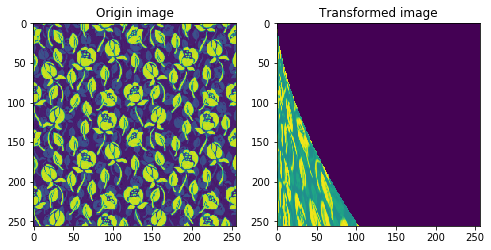

In [17]:
img = imread('Vintage-green-flower-seamless-pattern.jpg')
plt.figure(figsize = (8,10))
plt.imshow(img)
img = resize(img, (256, 256), preserve_range=True)[:,:,0]

plt.subplot(1,2,1)
plt.title('Origin image')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('Transformed image')

transformed = Image_Transformation(img)

plt.imshow(transformed)

plt.show();